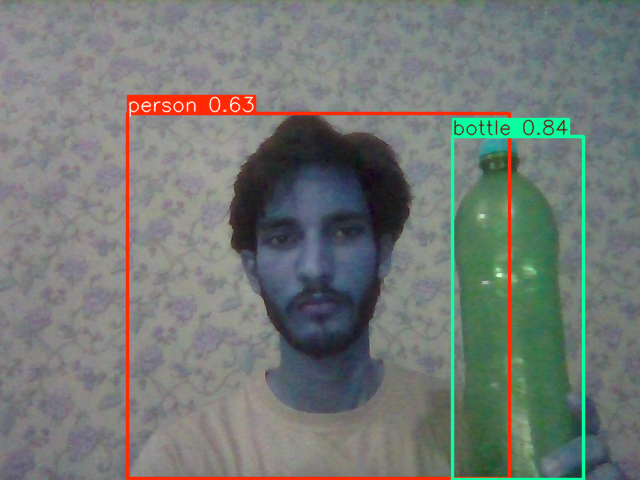

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [2]:
# Install required libraries
!pip install opencv-python-headless torch torchvision torchaudio
!pip install ultralytics

import torch
import numpy as np
from IPython.display import display, Javascript, clear_output
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
import io
import cv2
from ultralytics import YOLO

# JavaScript function to capture video frames
def capture_frame():
    js = Javascript('''
    async function captureFrame() {
      const div = document.createElement('div');
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      const ctx = canvas.getContext('2d');
      ctx.drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      document.body.removeChild(video);
      return canvas.toDataURL('image/jpeg');
    }
    ''')
    display(js)
    data = eval_js('captureFrame()')
    binary = b64decode(data.split(',')[1])
    return binary

# Load YOLOv8 model
model = YOLO('yolov8s.pt')  # Load YOLOv8 small model

def detect_objects(frame):
    try:
        # Convert binary image data to a NumPy array
        img_array = np.frombuffer(frame, dtype=np.uint8)

        # Decode the NumPy array into an image using OpenCV
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

        if img is None:
            raise ValueError("Failed to decode image data")

        # Perform object detection
        results = model(img)

        # YOLOv8 results are a list of Results objects, handle the first one
        if len(results) > 0:
            result = results[0]

            # Extract bounding boxes and labels
            img_result = result.plot()  # Plot the image with annotations

            # Convert result back to PIL Image
            img_result = Image.fromarray(img_result)

            return img_result
        else:
            raise ValueError("No detection results found")

    except Exception as e:
        print(f"Error in detect_objects: {e}")
        return None

# Real-time object detection loop
def real_time_object_detection():
    while True:
        try:
            # Capture frame
            frame = capture_frame()

            # Perform object detection
            img_result = detect_objects(frame)

            # Display the result
            if img_result:
                clear_output(wait=True)
                display(img_result)
            else:
                print("Error: Could not process the image.")

        except Exception as e:
            print(f"Error in real_time_object_detection: {e}")
            break

# Start real-time object detection
real_time_object_detection()
